In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime
from tqdm import tqdm
import yaml
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import hashlib

## 1. Load Dataset

In [2]:
x_rus = joblib.load("data/processed/x_rus.pkl")
y_rus = joblib.load("data/processed/y_rus.pkl")

x_ros = joblib.load("data/processed/x_ros.pkl")
y_ros = joblib.load("data/processed/y_ros.pkl")

x_sm = joblib.load("data/processed/x_sm.pkl")
y_sm = joblib.load("data/processed/y_sm.pkl")

x_valid = joblib.load("data/processed/x_valid.pkl")
y_valid = joblib.load("data/processed/y_valid.pkl")

x_test = joblib.load("data/processed/x_test.pkl")
y_test = joblib.load("data/processed/y_test.pkl")

## 2. Create Log Template

In [3]:
def time_stamp():
    return datetime.now()

In [4]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [5]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

## 2. Training and Evaluation

### 2.1. Create Model Object

In [6]:
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [7]:
list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

### 2.2. Training Model

In [8]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

#### 2.2.1. Baseline Model Undersampling

In [9]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\nvic\Desktop\Exercise\venv_win\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


In [10]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

#### 2.2.2. Baseline Model Oversampling

In [11]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "oversampling",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\nvic\Desktop\Exercise\venv_win\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


In [12]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

#### 2.2.3. Baseline Model SMOTE

In [13]:
training_log, list_of_model_sm = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_rus,
    y_rus,
    "smote",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\nvic\Desktop\Exercise\venv_win\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00, 14.12it/s]


In [14]:
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

#### 2.3.4. Best Performance

In [15]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [16]:
training_res = training_log_to_df(training_log)

100%|██████████| 3/3 [00:00<00:00, 187.43it/s]


In [17]:
training_res

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,a9ea4eefd9a6032ba95ef359981ab41c,0.002000,2022-11-02 17:47:57.647540,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,undersampling
1,baseline_model-DecisionTreeClassifier,2a38f9e1c9e4780345274841491c590f,0.002965,2022-11-02 17:47:59.153753,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,smote
2,baseline_model-DecisionTreeClassifier,10f0e518f65f057faa508a14876a6644,0.004003,2022-11-02 17:47:58.507712,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,oversampling
3,baseline_model-XGBClassifier,a09eef809e3104a8127951d04919aa1e,0.053965,2022-11-02 17:47:59.408748,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,smote
4,baseline_model-XGBClassifier,5ed82f2f9c964a04a526350e3a336b7f,0.068999,2022-11-02 17:47:58.752712,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,oversampling
5,baseline_model-XGBClassifier,4cf8362cc364566443b5ed28a2797f00,0.281174,2022-11-02 17:47:57.880538,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,undersampling
6,baseline_model-RandomForestClassifier,3504a16ca779c7a2b1078f8214601a63,0.170951,2022-11-02 17:47:58.524796,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.962534,oversampling
7,baseline_model-RandomForestClassifier,d8402eb52ba6740a3f42e2fda8f76d7a,0.185028,2022-11-02 17:47:57.655547,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.962534,undersampling
8,baseline_model-RandomForestClassifier,accd28117d0ba2ec79fa7bf4173af7d0,0.191998,2022-11-02 17:47:59.163756,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.962534,smote
9,baseline_model-LogisticRegression,9f39e56a6d3de5ce0dd1976b66b6ed15,0.024991,2022-11-02 17:47:59.118727,"{'0': {'precision': 0.65, 'recall': 0.92857142...",0.865546,smote


In [18]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object
    

In [19]:
model = get_best_model(training_res, list_of_model)

In [20]:
model

DecisionTreeClassifier()

In [21]:
joblib.dump(model, "models/model.pkl")

['models/model.pkl']

#### 2.2.5. Hyperparameter Tuning

In [22]:
dist_params_knn = {
    "algorithm" : ["ball_tree", "kd_tree", "brute"],
    "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
}

In [23]:
knn_enh = GridSearchCV(KNeighborsClassifier(), dist_params_knn, n_jobs = -1, verbose = 420)

In [24]:
list_of_model["undersampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["smote"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})

In [25]:
training_log, list_of_model_rus_hyp = train_eval_model(
    [list_of_model["undersampling"][-1]],
    "hyperparams",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


100%|██████████| 1/1 [00:08<00:00,  8.89s/it]


In [26]:
list_of_model["undersampling"][-1] = copy.deepcopy(list_of_model_rus_hyp[0])

In [27]:
list_of_model["undersampling"][-1]

{'model_name': 'GridSearchCV-KNeighborsClassifier',
 'model_object': GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [2, 3, 4, 5, 6, 10, 15, 20, 25],
                          'n_neighbors': [2, 3, 4, 5, 6, 10, 15, 20, 25]},
              verbose=420),
 'model_uid': '80d82d43ee93f12846947714c62195c7'}

In [28]:
training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00, 306.81it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,a9ea4eefd9a6032ba95ef359981ab41c,0.002000,2022-11-02 17:47:57.647540,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,undersampling
1,baseline_model-DecisionTreeClassifier,2a38f9e1c9e4780345274841491c590f,0.002965,2022-11-02 17:47:59.153753,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,smote
2,baseline_model-DecisionTreeClassifier,10f0e518f65f057faa508a14876a6644,0.004003,2022-11-02 17:47:58.507712,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,oversampling
3,baseline_model-XGBClassifier,a09eef809e3104a8127951d04919aa1e,0.053965,2022-11-02 17:47:59.408748,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,smote
4,baseline_model-XGBClassifier,5ed82f2f9c964a04a526350e3a336b7f,0.068999,2022-11-02 17:47:58.752712,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,oversampling
5,baseline_model-XGBClassifier,4cf8362cc364566443b5ed28a2797f00,0.281174,2022-11-02 17:47:57.880538,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,undersampling
6,baseline_model-RandomForestClassifier,3504a16ca779c7a2b1078f8214601a63,0.170951,2022-11-02 17:47:58.524796,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.962534,oversampling
7,baseline_model-RandomForestClassifier,d8402eb52ba6740a3f42e2fda8f76d7a,0.185028,2022-11-02 17:47:57.655547,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.962534,undersampling
8,baseline_model-RandomForestClassifier,accd28117d0ba2ec79fa7bf4173af7d0,0.191998,2022-11-02 17:47:59.163756,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.962534,smote
9,hyperparams-GridSearchCV-KNeighborsClassifier,80d82d43ee93f12846947714c62195c7,8.852611,2022-11-02 17:48:01.550718,"{'0': {'precision': 0.6363636363636364, 'recal...",0.871940,undersampling


#### 2.2.6. Take a Look at Confusion Matrix

In [29]:
y_pred = model.predict(x_valid)

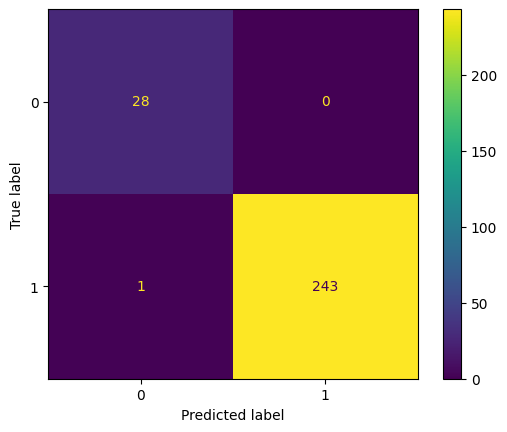

In [30]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)